In [1]:
# Importando pacotes
import joblib
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import mlflow
import mlflow.sklearn
%matplotlib inline 
import warnings
warnings.filterwarnings("ignore")

In [2]:
mlflow.set_experiment('Breast_Cancer_models')

2022/10/10 14:12:35 INFO mlflow.tracking.fluent: Experiment with name 'Breast_Cancer_models' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///C:/Users/dider/pyhton/Projetos_Portifolio/Breast_Cancer/mlruns/1', creation_time=1665421955655, experiment_id='1', last_update_time=1665421955655, lifecycle_stage='active', name='Breast_Cancer_models', tags={}>

In [3]:
# Funçoes auxiliares

def get_redundant_pairs(df):
    """Get diagonal and lower triangular pairs of correlation matrix"""
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    """Sort correlations in the descending order and return n highest results"""
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

def identify_correlated(df, threshold):
    """
    A function to identify highly correlated features.
    """
    # Compute correlation matrix with absolute values
    matrix = df.corr().abs()
    mask = np.triu(np.ones_like(matrix, dtype=bool))
    
    # Subset the matrix
    reduced_matrix = matrix.mask(mask)
    
    # Find cols that meet the threshold
    to_drop = [c for c in reduced_matrix.columns if \
              any(reduced_matrix[c] > threshold)]
    
    return to_drop


In [4]:
from sklearn.datasets import load_breast_cancer
dados = load_breast_cancer()

In [5]:
# Unindo em um unico DataFrame
df = pd.DataFrame(data = dados.data, columns = dados.feature_names)
df['target'] = pd.Series(dados.target)

In [6]:
df

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0


In [7]:
df.shape

(569, 31)

## Analise exploratoria

In [8]:
df.dtypes

mean radius                float64
mean texture               float64
mean perimeter             float64
mean area                  float64
mean smoothness            float64
mean compactness           float64
mean concavity             float64
mean concave points        float64
mean symmetry              float64
mean fractal dimension     float64
radius error               float64
texture error              float64
perimeter error            float64
area error                 float64
smoothness error           float64
compactness error          float64
concavity error            float64
concave points error       float64
symmetry error             float64
fractal dimension error    float64
worst radius               float64
worst texture              float64
worst perimeter            float64
worst area                 float64
worst smoothness           float64
worst compactness          float64
worst concavity            float64
worst concave points       float64
worst symmetry      

In [9]:
df['target'].value_counts()

1    357
0    212
Name: target, dtype: int64

Dataset está identificado com a label "1" quando o tumor é benigno e "0" quando o tumor é maligno

In [10]:
def ajusta_var(x):
    if x == 1:
        return 'B'
    return 'M'

In [11]:
df['target'] = df['target'].map(ajusta_var)

In [12]:
df['target'].value_counts()

B    357
M    212
Name: target, dtype: int64

In [13]:
def ajusta_var(x):
    if x == 'B':
        return 0
    return 1

In [14]:
df['target'] = df['target'].map(ajusta_var)

In [15]:
df['target'].value_counts()

0    357
1    212
Name: target, dtype: int64

### Verificando correlações

<AxesSubplot:xlabel='mean radius', ylabel='mean perimeter'>

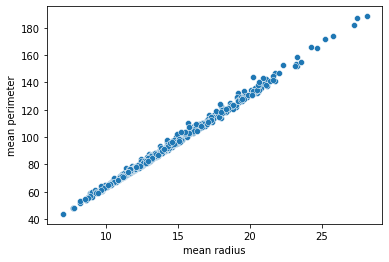

In [16]:
# verificando algumas correlações
sns.scatterplot(data=df,x='mean radius',y='mean perimeter')

<AxesSubplot:xlabel='worst perimeter', ylabel='worst radius'>

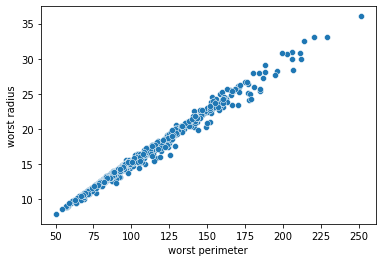

In [17]:
sns.scatterplot(data=df,x='worst perimeter',y='worst radius')

<AxesSubplot:xlabel='mean area', ylabel='mean radius'>

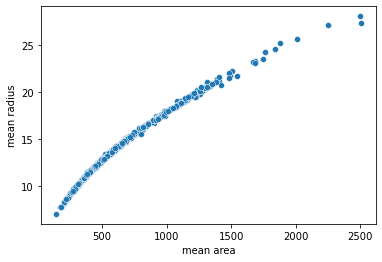

In [18]:
sns.scatterplot(data=df,x='mean area',y='mean radius')

<AxesSubplot:xlabel='worst area', ylabel='mean area'>

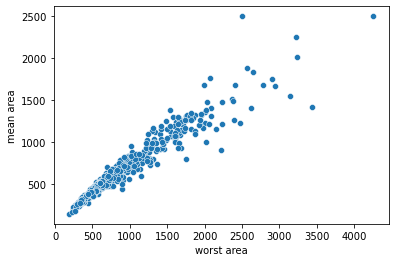

In [19]:
sns.scatterplot(data=df,x='worst area',y='mean area')

In [20]:
get_top_abs_correlations(df,15).reset_index().rename(columns = {'level_0':'feature 1', 'level_1':'feature 2', 0:'corr'})

,feature 1,feature 2,corr
0,mean radius,mean perimeter,0.997855
1,worst radius,worst perimeter,0.993708
2,mean radius,mean area,0.987357
3,mean perimeter,mean area,0.986507
4,worst radius,worst area,0.984015
5,worst perimeter,worst area,0.977578
6,radius error,perimeter error,0.972794
7,mean perimeter,worst perimeter,0.970387
8,mean radius,worst radius,0.969539
9,mean perimeter,worst radius,0.969476


Como muitas das variaveis entao relacionadas a areas e medidas de distancia como perimetro ou pior perimetro, muitas (quase todas)
as variaveis tem uma correlação muito forte, o que pode gerar problemas de multicolinearidade

In [21]:
df.columns

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension',
       'target'],
      dtype='object')

Nesse estudo de caso optarei por tirar todas as variaveis que representao "worst", "Perimeter", "Radius" e "error" pois acredito que as variais que representam a media ou area de algo terão mais impacto na previsão

In [22]:
drop = ['mean radius','mean perimeter','worst radius','worst texture','worst perimeter',
        'worst area','worst smoothness','worst compactness','worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension','radius error',
        'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error','mean concavity']

In [23]:
df_mc =  df.drop(drop,axis=1)
df_mc

,mean texture,mean area,mean smoothness,mean compactness,mean concave points,mean symmetry,mean fractal dimension,target
0,10.38,1001.0,0.11840,0.27760,0.14710,0.2419,0.07871,1
1,17.77,1326.0,0.08474,0.07864,0.07017,0.1812,0.05667,1
2,21.25,1203.0,0.10960,0.15990,0.12790,0.2069,0.05999,1
3,20.38,386.1,0.14250,0.28390,0.10520,0.2597,0.09744,1
4,14.34,1297.0,0.10030,0.13280,0.10430,0.1809,0.05883,1
...,...,...,...,...,...,...,...,...
564,22.39,1479.0,0.11100,0.11590,0.13890,0.1726,0.05623,1
565,28.25,1261.0,0.09780,0.10340,0.09791,0.1752,0.05533,1
566,28.08,858.1,0.08455,0.10230,0.05302,0.1590,0.05648,1
567,29.33,1265.0,0.11780,0.27700,0.15200,0.2397,0.07016,1


In [24]:
df_corr = get_top_abs_correlations(df_mc,10).reset_index()
df_corr.rename(columns = {'level_0':'feature 1', 'level_1':'feature 2', 0:'corr'})

,feature 1,feature 2,corr
0,mean compactness,mean concave points,0.831135
1,mean area,mean concave points,0.823269
2,mean concave points,target,0.776614
3,mean area,target,0.708984
4,mean smoothness,mean compactness,0.659123
5,mean compactness,mean symmetry,0.602641
6,mean compactness,target,0.596534
7,mean smoothness,mean fractal dimension,0.584792
8,mean compactness,mean fractal dimension,0.565369
9,mean smoothness,mean symmetry,0.557775


**Com isso o dataset foi reduzido para 8 colunas e ficando com uma correlaçõa maxima de 0.83 entre as variaveis**

## Limpeza dos dados

In [25]:
#verificando valores nulos
df_mc.isna().sum()

mean texture              0
mean area                 0
mean smoothness           0
mean compactness          0
mean concave points       0
mean symmetry             0
mean fractal dimension    0
target                    0
dtype: int64

In [26]:
# verifanco outliers
df_mc.describe()

,mean texture,mean area,mean smoothness,mean compactness,mean concave points,mean symmetry,mean fractal dimension,target
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,19.289649,654.889104,0.096360,0.104341,0.048919,0.181162,0.062798,0.372583
std,4.301036,351.914129,0.014064,0.052813,0.038803,0.027414,0.007060,0.483918
min,9.710000,143.500000,0.052630,0.019380,0.000000,0.106000,0.049960,0.000000
25%,16.170000,420.300000,0.086370,0.064920,0.020310,0.161900,0.057700,0.000000
50%,18.840000,551.100000,0.095870,0.092630,0.033500,0.179200,0.061540,0.000000
75%,21.800000,782.700000,0.105300,0.130400,0.074000,0.195700,0.066120,1.000000
max,39.280000,2501.000000,0.163400,0.345400,0.201200,0.304000,0.097440,1.000000


**Pela tabela de describe, analisando a média e valores maximos e minimos, o dataset nao parece apresnetar valores outliers, porem
isso será comprovado com o boxplot das features.**

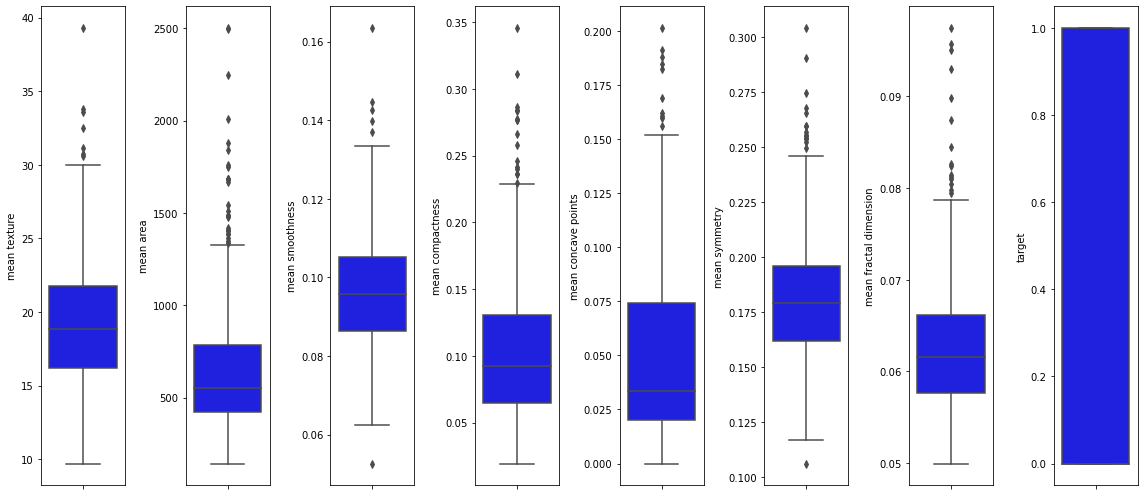

In [27]:
cols = df_mc.columns
plt.figure(figsize=(16,7))
for i in range(0, len(cols)):
    plt.subplot(1, len(cols), i + 1)
    sns.boxplot(y = df_mc[df_mc.columns[i]], color = 'blue', orient = 'v')
    plt.tight_layout()

**por mais que o boxplot mostre valores outliers, nao acredito que esses valores são muitos discrepantes da media, por isso,
em primeiro momento vou optar por nao retirar esse valores.**

## Pré-Processamento de Dados Para Construção de Modelos de Machine Learning

In [28]:
# Dividindo os dados em features e target
X = df_mc.drop('target', axis=1)
y = df_mc.target

In [29]:
# Dados de treino e dados de teste
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3,random_state = 123)

In [30]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(398, 7) (171, 7) (398,) (171,)


### Balanceamento de Classe

In [31]:
# Carrega a função SMOTE
import imblearn
from imblearn.over_sampling import SMOTE

In [32]:
# temos valores desbalanceados de classe
y_train.value_counts()

0    254
1    144
Name: target, dtype: int64

In [33]:
over_sampler = SMOTE(k_neighbors = 5)

In [34]:
X_res, y_res = over_sampler.fit_resample(X_train, y_train)

In [35]:
# apos aplicar a função SMOTE a classe foi balanceada criando novas amostras sinteticas
y_res.value_counts()

0    254
1    254
Name: target, dtype: int64

In [36]:
X_train = X_res
y_train = y_res

### Padronização dos Dados

In [37]:
scaler = StandardScaler()

In [38]:
X_train = scaler.fit_transform(X_train)

In [39]:
X_test = scaler.transform(X_test)

## Criação dos modelos

### Construção, Treinamento e Avaliação do Modelo 1 com Regressão Logística (Benchmark)

In [40]:
# Define lista de hiperparâmetros
tuned_params_v1 = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000], 
                   'penalty': ['l1', 'l2']}

# Vários modelos serão criados com diferentes combinações de hiperparâmetros
gridcv = GridSearchCV(LogisticRegression(), 
                         tuned_params_v1, 
                         scoring = 'roc_auc', 
                         n_jobs = -1)

# Treinamento do modelo
gridcv.fit(X_train, y_train)

# Melhor modelo
modelo_v1 = gridcv.best_estimator_

In [41]:
y_pred_v1 = modelo_v1.predict(X_test)

In [42]:
confusion_matrix(y_test, y_pred_v1)

array([[100,   3],
       [  5,  63]], dtype=int64)

In [43]:
modelo_v1

LogisticRegression(C=1)

In [44]:
# Obtemos as previsões no formato de probabilidade filtrando para a classe positiva
# Precisamos disso para calcula a Curva ROC
y_pred_proba_v1 = modelo_v1.predict_proba(X_test)[:,1]


# Metricas
with mlflow.start_run():
    roc_auc_v1 = roc_auc_score(y_test,y_pred_proba_v1)
    acuracia_v1 = accuracy_score(y_test,y_pred_v1)
    
    mlflow.log_param('C',1)
    mlflow.log_metric("roc_auc", roc_auc_v1)
    mlflow.log_metric("acuracia", acuracia_v1)
    
    mlflow.sklearn.log_model(modelo_v1,'Logistic Regression')
    mlflow.set_tag("mlflow.runName", "Logistic Regression")

2022/10/10 14:12:40 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial warning can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|none|n|0: for no warning or exception
    - warn|w|warning|1: for a printed warning
    - error|e|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



In [45]:
# Dicionário com as métricas do modelo_v1
dict_modelo_v1 = {'Nome': 'modelo_v1', 
                  'Algoritmo': 'Regressão Logística', 
                  'ROC_AUC Score': roc_auc_v1,
                  'Acurácia': acuracia_v1}

### Random forest

In [46]:
clf = RandomForestClassifier(random_state = 99)

# Definição dos parâmetros
param_dist = {"max_depth": [1, 3, 7, None],
              "max_features": [8, 9],
              "min_samples_split": [8, 10],
              "min_samples_leaf": [1, 2, 3],
              "bootstrap": [True, False]}

# Para o classificador criado com ExtraTrees, testamos diferentes combinações de parâmetros
rsearch = RandomizedSearchCV(clf, 
                             param_distributions = param_dist, 
                             n_iter = 25, 
                             return_train_score = True)  

# Aplicando o resultado ao conjunto de dados de treino e obtendo o score
rsearch.fit(X_train, y_train)

# Resultados 
rsearch.cv_results_

# Imprimindo o melhor estimador
bestclf = rsearch.best_estimator_
print(bestclf)

RandomForestClassifier(max_features=8, min_samples_leaf=2, min_samples_split=8,
                       random_state=99)


In [47]:
modelo_v2 = bestclf

# Previsões com o modelo
y_pred_v2 = modelo_v2.predict(X_test)

# Previsões de probabilidade
y_pred_proba_v2 = modelo_v2.predict_proba(X_test)[:,1]

# Roc_auc
roc_auc_v2 = roc_auc_score(y_test,y_pred_proba_v2)

# acuracia
acuracia_v2 = accuracy_score(y_test,y_pred_v2)

with mlflow.start_run():
    roc_auc_v2 = roc_auc_score(y_test,y_pred_proba_v2)
    acuracia_v2 = accuracy_score(y_test,y_pred_v2)
    
    mlflow.log_metric("roc_auc", roc_auc_v2)
    mlflow.log_metric("acuracia", acuracia_v2)
    
    mlflow.sklearn.log_model(modelo_v2,'Random Forest')
    mlflow.set_tag("mlflow.runName", "Random Forest")

In [48]:
# Matriz de confusão
confusion_matrix(y_test,y_pred_v2)

array([[96,  7],
       [ 7, 61]], dtype=int64)

In [49]:
# Dicionário com as métricas do modelo_v2
dict_modelo_v2 = {'Nome': 'modelo_v2', 
                  'Algoritmo': 'Random forest', 
                  'ROC_AUC Score': roc_auc_v2,
                  'Acurácia': acuracia_v2}

### Decision tree

In [50]:
dtc = DecisionTreeClassifier()

# Definição dos parâmetros
param_dist_v3 = {"criterion": ['gini', 'entropy', 'log_loss'],
              "max_depth": [8, 9, 10, 11],
              "min_samples_split": [8, 10, 11, 14],
              "min_samples_leaf": [1, 2, 3, 4, 5, 6]}

# Para o classificador criado com ExtraTrees, testamos diferentes combinações de parâmetros
rsearch_v3 = RandomizedSearchCV(dtc, 
                             param_distributions = param_dist_v3, 
                             n_iter = 25, 
                             return_train_score = True)

# Treinar o modelo
rsearch_v3.fit(X_train, y_train)

# Melhores parametos
modelo_v3 = rsearch_v3.best_estimator_

In [51]:
# previsões do modelo
y_pred_v3 = modelo_v3.predict(X_test)

# Previsões de probabilidade
y_pred_proba_v3 = modelo_v3.predict_proba(X_test)[:,1]

# Matrz de confusão
confusion_matrix(y_test,y_pred_v3)

with mlflow.start_run():
    roc_auc_v3 = roc_auc_score(y_test,y_pred_proba_v3)
    acuracia_v3 = accuracy_score(y_test,y_pred_v3)
    
    mlflow.log_metric("roc_auc", roc_auc_v3)
    mlflow.log_metric("acuracia", acuracia_v3)
    
    mlflow.sklearn.log_model(modelo_v3,'Decision Tree')
    mlflow.set_tag("mlflow.runName", "Decision Tree")

In [52]:
# Dicionário com as métricas do modelo_v3
dict_modelo_v3 = {'Nome': 'modelo_v3', 
                  'Algoritmo': 'Decision tree', 
                  'ROC_AUC Score': roc_auc_v3,
                  'Acurácia': acuracia_v3}

### KNN

In [53]:
knn = KNeighborsClassifier()

# Definição dos parâmetros
param_dist = {"n_neighbors": [1, 3, 5, 7],
              "weights": ['uniform', 'distance']}

# GridSearchCV
gridcv_v4 = GridSearchCV(knn,
                         param_dist, 
                         scoring = 'roc_auc', 
                         n_jobs = -1)

# treiamento do modelo
gridcv_v4.fit(X_train,y_train)

# Melhor modelo
modelo_v4 = gridcv_v4.best_estimator_
print(modelo_v4)

KNeighborsClassifier(n_neighbors=7, weights='distance')


In [54]:
# previsões do modelo
y_pred_v4 = modelo_v4.predict(X_test)

y_pred_proba_v4 = modelo_v4.predict_proba(X_test)[:,1]

# Metricas do modelo
with mlflow.start_run():
    roc_auc_v4 = roc_auc_score(y_test,y_pred_proba_v4)
    acuracia_v4 = accuracy_score(y_test,y_pred_v4)
    
    mlflow.log_metric("roc_auc", roc_auc_v4)
    mlflow.log_metric("acuracia", acuracia_v4)
    
    mlflow.sklearn.log_model(modelo_v4,'KNN')
    mlflow.set_tag("mlflow.runName", "KNN")

In [55]:
# Dicionário com as métricas do modelo_v4
dict_modelo_v4 = {'Nome': 'modelo_v4', 
                  'Algoritmo': 'KNN', 
                  'ROC_AUC Score': roc_auc_v4,
                  'Acurácia': acuracia_v4}

In [59]:
df_modelos = pd.DataFrame()

df_modelos.append([dict_modelo_v1,dict_modelo_v2,dict_modelo_v3,dict_modelo_v4],ignore_index = True).sort_values(by='ROC_AUC Score', ascending = False)

,Nome,Algoritmo,ROC_AUC Score,Acurácia
0,modelo_v1,Regressão Logística,0.987436,0.953216
1,modelo_v2,Random forest,0.976728,0.918129
3,modelo_v4,KNN,0.975585,0.923977
2,modelo_v3,Decision tree,0.920403,0.894737


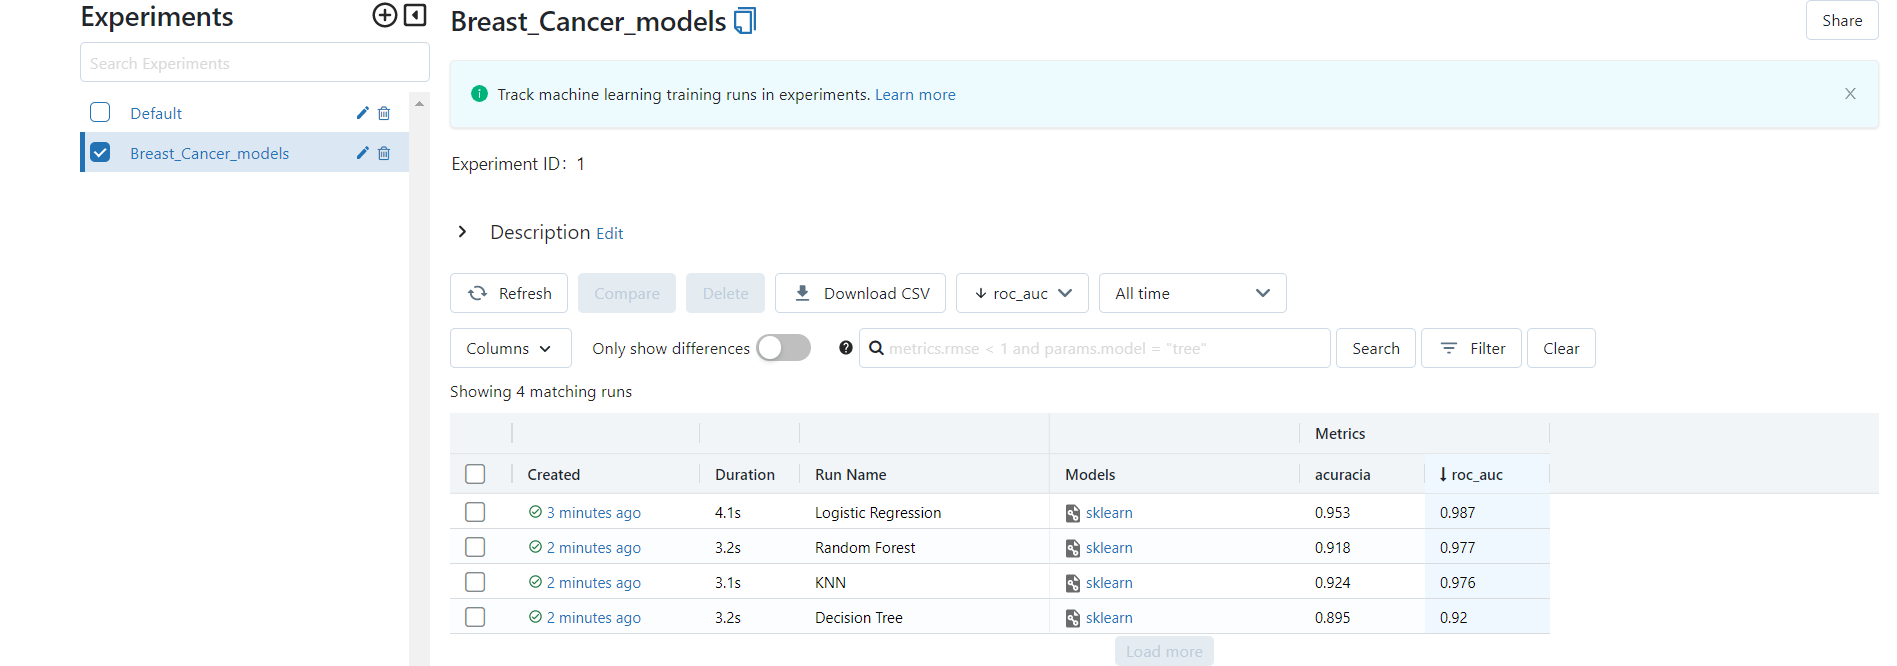

In [57]:
from IPython.display import Image
Image("Captura de tela 2022-10-10 142038.png")